In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 2500  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 100      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 32
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

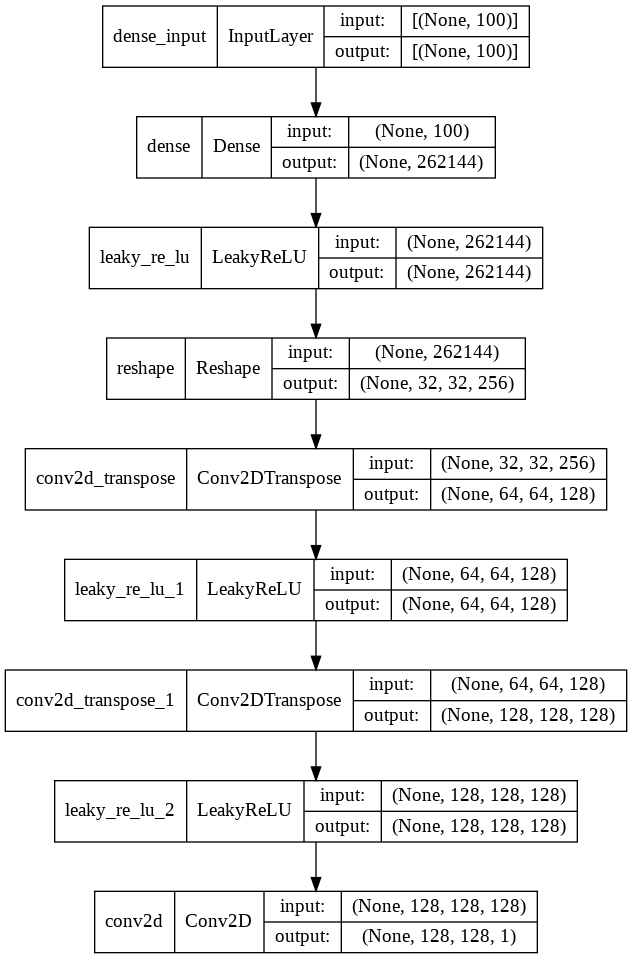

In [ ]:
model=create_generator_cgan()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
a=create_generator_cgan()
a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 262144)            26476544  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 262144)            0         
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 128)      524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 128, 128, 128)    262272    
 ranspose)                                            

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [ ]:
dis=create_discriminator_cgan()

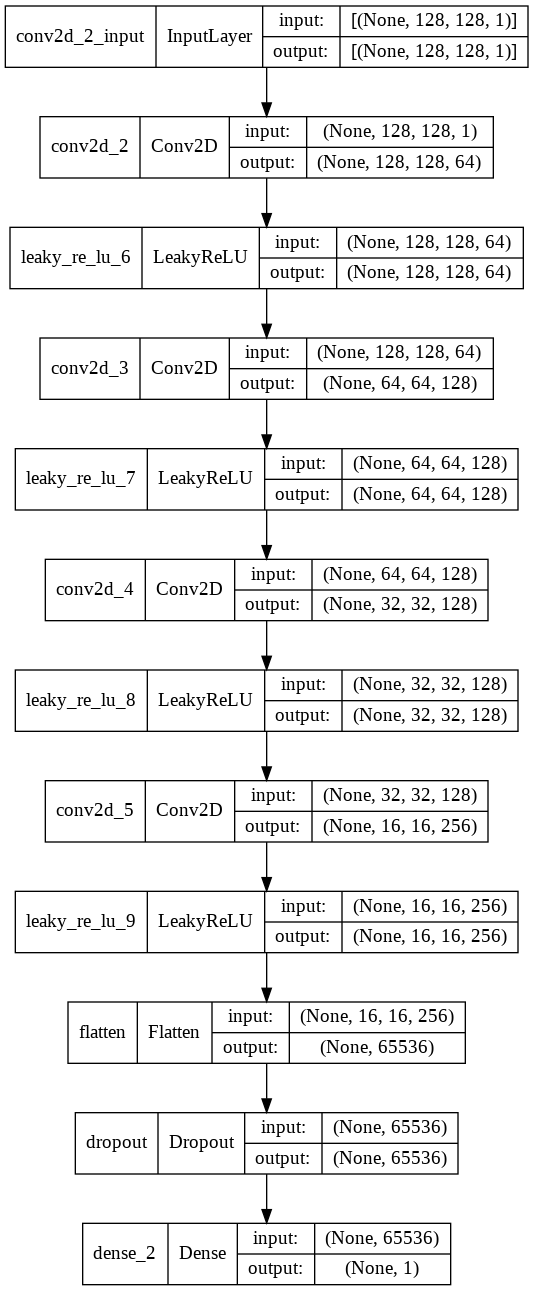

In [ ]:
plot_model(dis, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

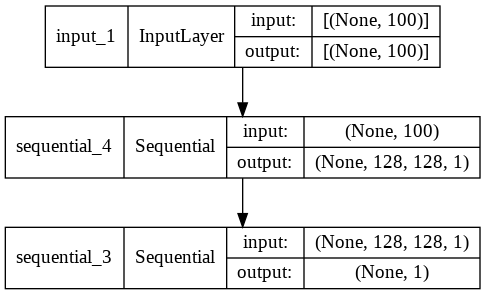

In [ ]:
plot_model(gan, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**DATA LOADING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
x=np.load('/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/non zeros masks/non zeros masks.npy')

In [ ]:
x.shape

(13393, 128, 128)

In [ ]:
image2D = []
#mask2D = []
for i in range(195):
  for j in range(128):
    
    image2D.append(x[i,:,:,j])
    #mask2D.append(y[i,:,:,j])
x = np.array(image2D)
#y = np.array(mask2D)

In [ ]:
x.shape

(13393, 128, 128)

In [ ]:
d = 2.*(x - np.min(x))/np.ptp(x)-1

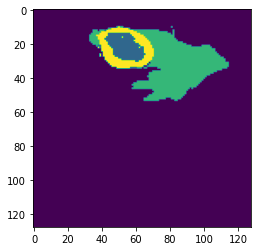

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(d[51])

In [ ]:
np.unique(d[51])

array([-1.        , -0.33333333,  0.33333333,  1.        ])

In [ ]:
x_train = np.expand_dims(d, axis = 3)

In [ ]:
x_train.shape

(13393, 128, 128, 1)

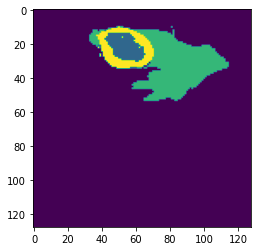

In [ ]:
plt.imshow(x_train[51,:,:,0])

In [ ]:
import matplotlib.pyplot as plt
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)))    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [ ]:
saved_model_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/full model'
saved_model_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/generator'
saved_model_discrimator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/discrimantor'

Epoch: 1 	 Discriminator Loss: 0.3360128402709961 		 Generator Loss: 1.8294336795806885


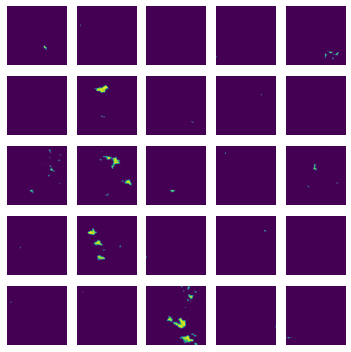

Epoch: 2 	 Discriminator Loss: 0.3698170781135559 		 Generator Loss: 1.9178290367126465


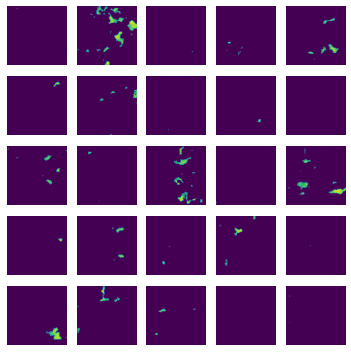

Epoch: 3 	 Discriminator Loss: 0.22583603858947754 		 Generator Loss: 2.7959651947021484


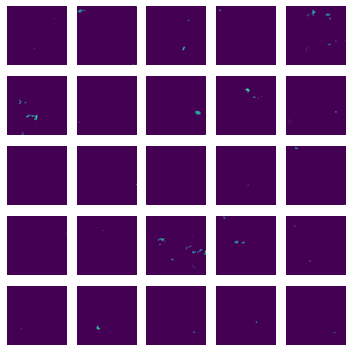

Epoch: 4 	 Discriminator Loss: 0.19761377573013306 		 Generator Loss: 3.553009510040283


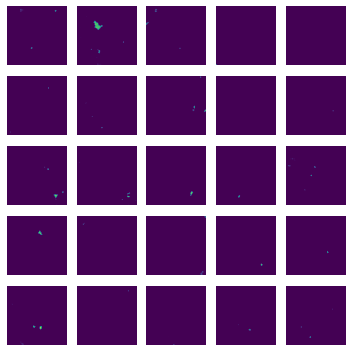

Epoch: 5 	 Discriminator Loss: 0.32600468397140503 		 Generator Loss: 2.3939120769500732


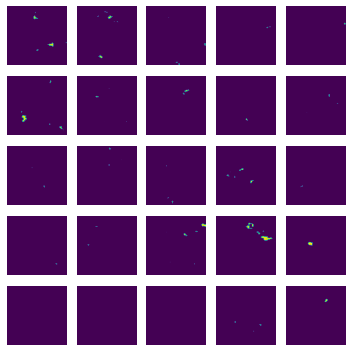

Epoch: 6 	 Discriminator Loss: 0.3021221160888672 		 Generator Loss: 2.676170587539673


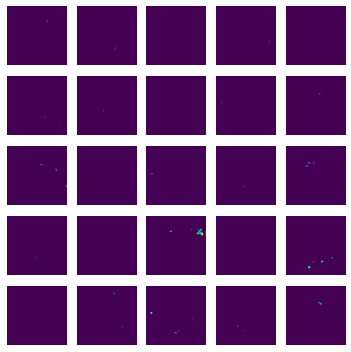

Epoch: 7 	 Discriminator Loss: 0.294522762298584 		 Generator Loss: 2.9033563137054443


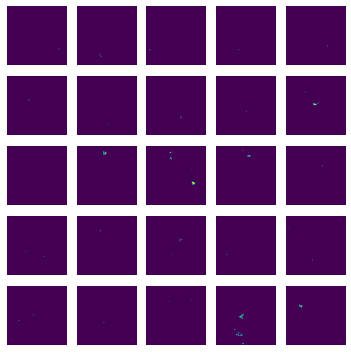

Epoch: 8 	 Discriminator Loss: 0.33805346488952637 		 Generator Loss: 2.8286421298980713


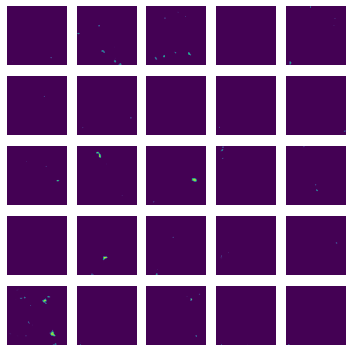

Epoch: 9 	 Discriminator Loss: 0.26521962881088257 		 Generator Loss: 2.906770706176758


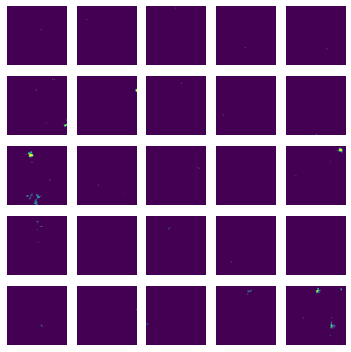

Epoch: 10 	 Discriminator Loss: 0.236856609582901 		 Generator Loss: 3.194152355194092


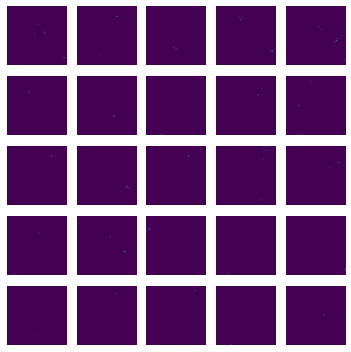

Epoch: 11 	 Discriminator Loss: 0.1993117779493332 		 Generator Loss: 3.4319615364074707


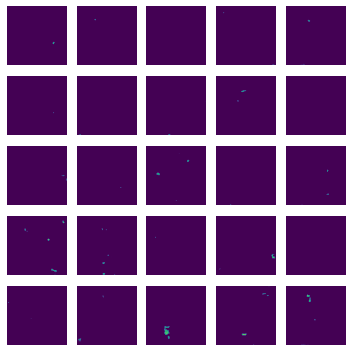

Epoch: 12 	 Discriminator Loss: 0.27117404341697693 		 Generator Loss: 3.749579429626465


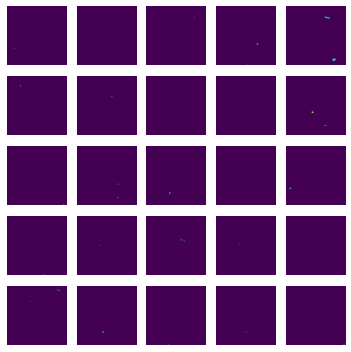

Epoch: 13 	 Discriminator Loss: 0.20877298712730408 		 Generator Loss: 3.2801594734191895


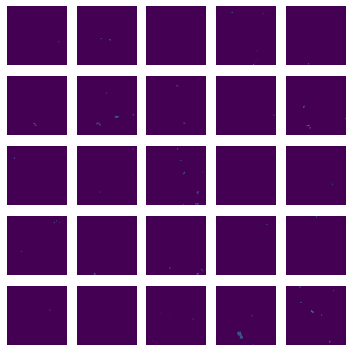

Epoch: 14 	 Discriminator Loss: 0.2703250050544739 		 Generator Loss: 3.369781970977783


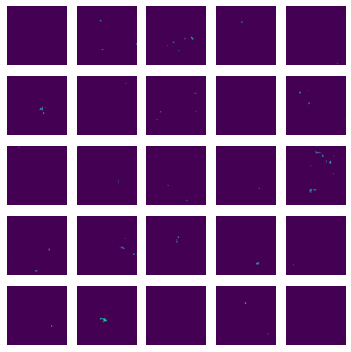

Epoch: 15 	 Discriminator Loss: 0.20286476612091064 		 Generator Loss: 3.2389965057373047


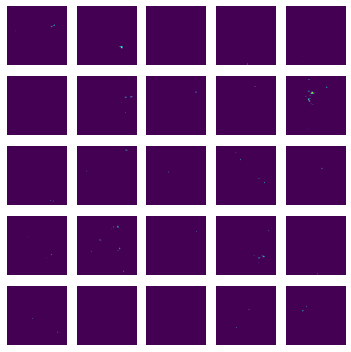

Epoch: 16 	 Discriminator Loss: 0.2029462456703186 		 Generator Loss: 3.5708279609680176


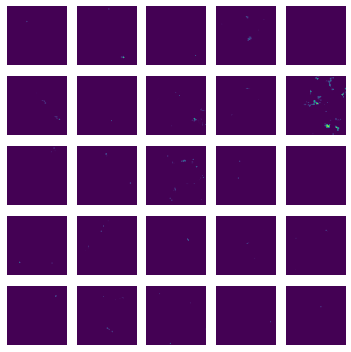

Epoch: 17 	 Discriminator Loss: 0.24370096623897552 		 Generator Loss: 3.377241611480713


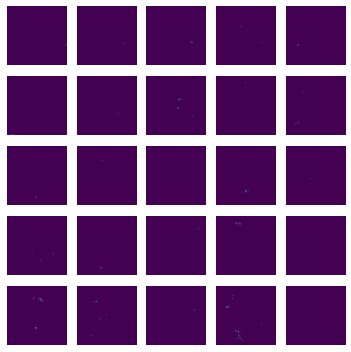

Epoch: 18 	 Discriminator Loss: 0.24525292217731476 		 Generator Loss: 3.5158908367156982


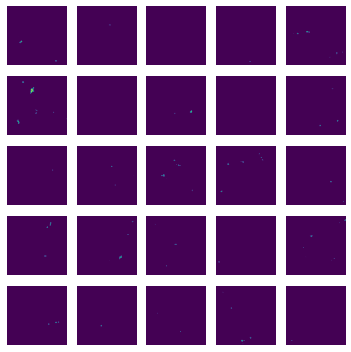

Epoch: 19 	 Discriminator Loss: 0.19775380194187164 		 Generator Loss: 3.4242987632751465


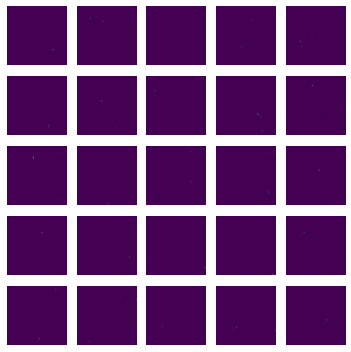

Epoch: 20 	 Discriminator Loss: 0.20125508308410645 		 Generator Loss: 3.745694875717163


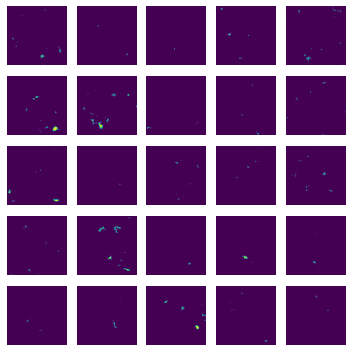

Epoch: 21 	 Discriminator Loss: 0.2525627911090851 		 Generator Loss: 3.758575916290283


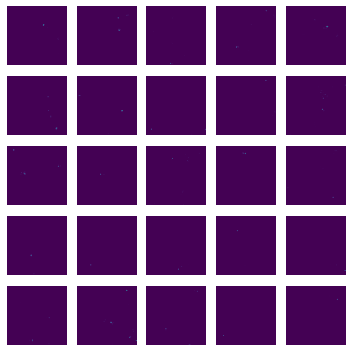

Epoch: 22 	 Discriminator Loss: 0.20850257575511932 		 Generator Loss: 3.811919927597046


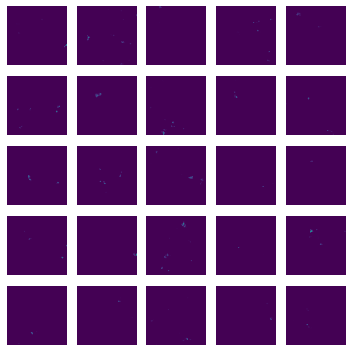

Epoch: 23 	 Discriminator Loss: 0.1856815218925476 		 Generator Loss: 4.079995155334473


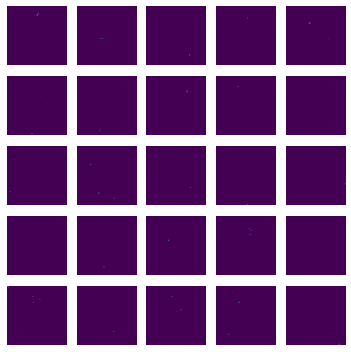

Epoch: 24 	 Discriminator Loss: 0.1891907900571823 		 Generator Loss: 3.9234533309936523


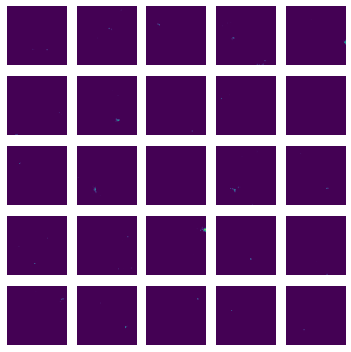

Epoch: 25 	 Discriminator Loss: 0.21779301762580872 		 Generator Loss: 3.676391124725342


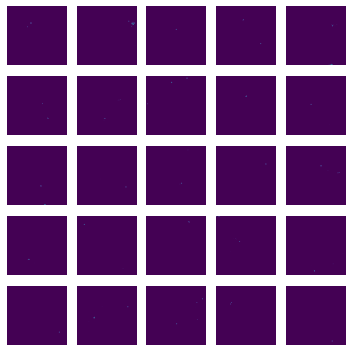

Epoch: 26 	 Discriminator Loss: 0.19747082889080048 		 Generator Loss: 3.825456142425537


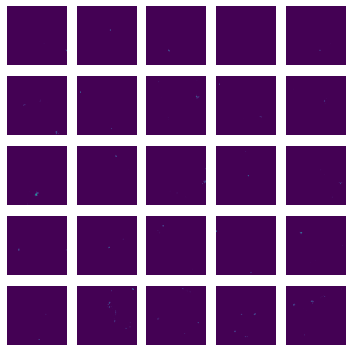

Epoch: 27 	 Discriminator Loss: 0.39574962854385376 		 Generator Loss: 3.6568527221679688


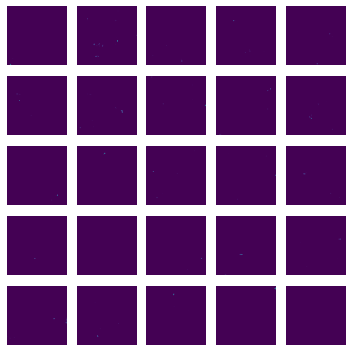

Epoch: 28 	 Discriminator Loss: 0.17965298891067505 		 Generator Loss: 4.265519142150879


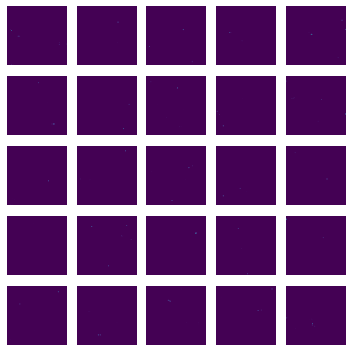

Epoch: 29 	 Discriminator Loss: 0.18645253777503967 		 Generator Loss: 4.191765308380127


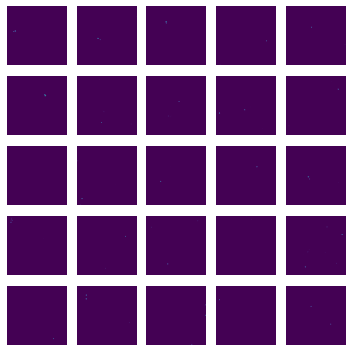

Epoch: 30 	 Discriminator Loss: 0.19014672935009003 		 Generator Loss: 3.913731098175049


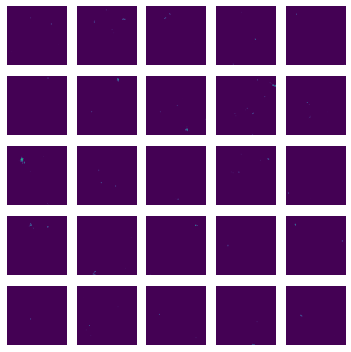

Epoch: 31 	 Discriminator Loss: 0.17728769779205322 		 Generator Loss: 4.394906997680664


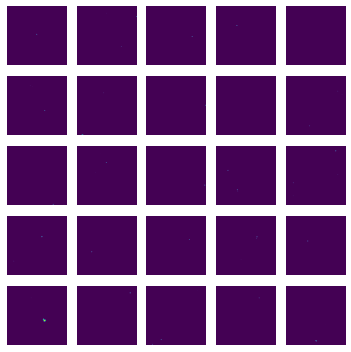

Epoch: 32 	 Discriminator Loss: 0.18617722392082214 		 Generator Loss: 4.012199401855469


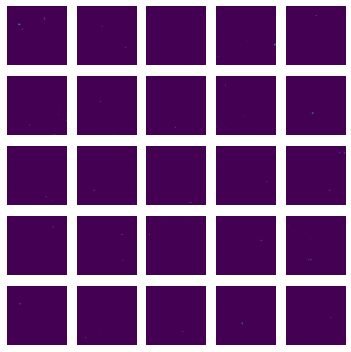

Epoch: 33 	 Discriminator Loss: 0.1801927238702774 		 Generator Loss: 4.512228965759277


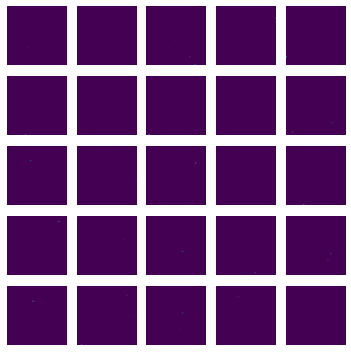

Epoch: 34 	 Discriminator Loss: 0.18133999407291412 		 Generator Loss: 4.479999542236328


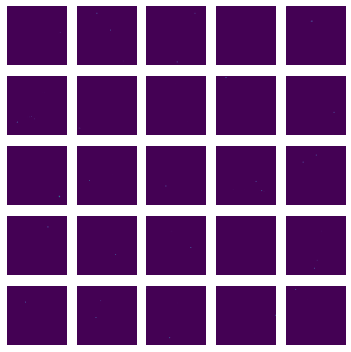

Epoch: 35 	 Discriminator Loss: 0.19646193087100983 		 Generator Loss: 4.040709495544434


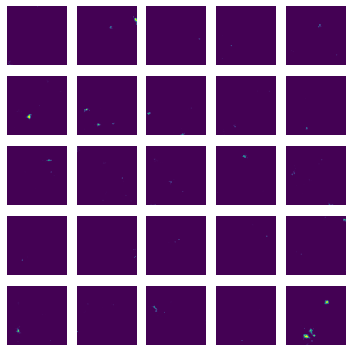

Epoch: 36 	 Discriminator Loss: 0.2367347925901413 		 Generator Loss: 4.079824924468994


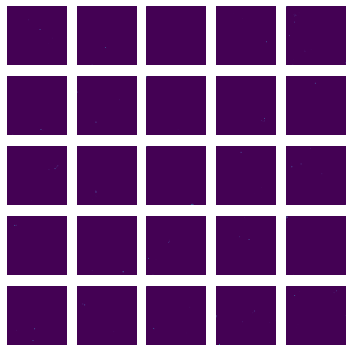

Epoch: 37 	 Discriminator Loss: 0.2032654732465744 		 Generator Loss: 3.7171216011047363


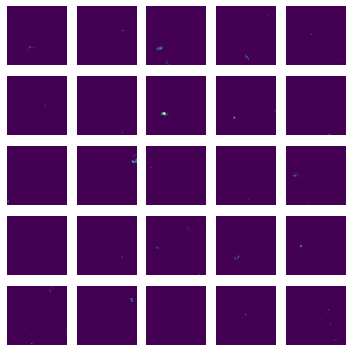

Epoch: 38 	 Discriminator Loss: 0.18305820226669312 		 Generator Loss: 4.4460601806640625


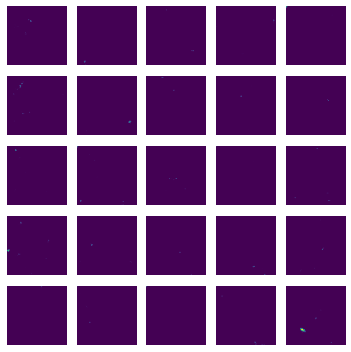

Epoch: 39 	 Discriminator Loss: 0.17764653265476227 		 Generator Loss: 4.317355632781982


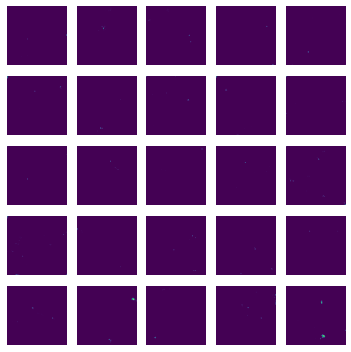

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]###check this line  and its value in the first dimensions
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

In [ ]:
path_discrim='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/discrimator'
path_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/generator'
path_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/full model'

In [ ]:
generator.save(path_generator)
gan.save(path_gan)
discriminator.save(path_discrim)

In [ ]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
fake_x = generator.predict(noise)

In [ ]:
fake_image.shape

TensorShape([None, 128, 128, 1])

TypeError: ignored

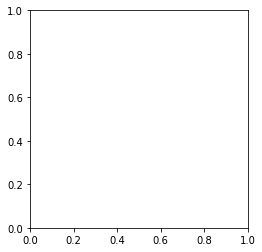

In [ ]:
plt.imshow(fake_image)

In [ ]:
generated_images.shape

(25, 128, 128, 1)

In [ ]:
np.unique(generated_images)

array([0.       , 0.9311627, 1.5658729], dtype=float32)

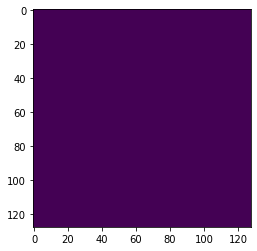

In [ ]:
plt.imshow(generated_images[23,:,:,0])

In [ ]:
np.max(generated_images[14:,:,0])

0.0

In [ ]:
np.unique(generated_images[17,:,:,0])

array([0.], dtype=float32)

In [ ]:
a=real_x[3,:,:,0]

In [ ]:
np.unique(a)

array([0.        , 0.66666667])

In [ ]:
np.unique(noise)

array([0, 1, 2, 3])

In [ ]:
generated_images = generator.predict(noise)

In [ ]:
generated_images.shape

(16, 128, 128, 1)

In [ ]:
a=generated_images[13,:,:,0]

In [ ]:
np.unique(a)

array([0.], dtype=float32)

In [ ]:
np.max(a)

0.0